# Digital Adoption Analysis using Random Forest

This notebook analyzes survey data on digital tool adoption by small businesses and predicts future digital adoption intent.

In [8]:
# Import required libraries for data processing, machine learning, visualization, and model evaluation
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO

In [9]:
# Load survey data from CSV file into a pandas DataFrame
df = pd.read_csv('./bengalSurvey.csv')

In [10]:
# Convert Likert scale responses to numeric values (1-5) for analysis
likert_cols = [col for col in df.columns if col not in [
    'Timestamp', 'Location', 'Shop/Owner/Business Name',
    'My shop accepts UPI/mobile payments.',
    'I have used any online marketplace (e.g., local delivery apps or e-commerce) to sell my products.'
]]

for col in likert_cols:
    df[col] = df[col].str.lower().str.strip().map({
        'strongly agree': 5,
        'agree': 4,
        'neutral': 3,
        'disagree': 2,
        'strongly disagree': 1
    }).fillna(3)

In [11]:
# Convert binary Yes/No responses to numeric values (1 for Yes, 0 for No)
binary_cols = [
    'My shop accepts UPI/mobile payments.',
    'I have used any online marketplace (e.g., local delivery apps or e-commerce) to sell my products.'
]

for col in binary_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0}).fillna(0)

In [12]:
# Display first few rows of the encoded dataset to verify data transformation
display(df.head())

,Timestamp,Location,Shop/Owner/Business Name,"I own or use a smartphone for my business activities (ordering, payments, messaging).",I regularly use the internet (WhatsApp/social media) to communicate with customers or suppliers.,My shop accepts UPI/mobile payments.,"I have used any online marketplace (e.g., local delivery apps or e-commerce) to sell my products.",I avoid digital tools because I find them too difficult to use.,Accepting digital payments (UPI/cards) increased the number of customers who buy from me.,Using digital payments helps prevent theft or loss of cash in my shop.,Transaction fees or costs for digital payments are a burden for my business.,Using digital payments made bookkeeping (tracking sales) easier for me.,Using digital tools helped me increase sales and reach new customers beyond my local area.,Digital messaging and ordering helped me get repeat customers and made daily operations faster.,"I spend money to maintain digital services (mobile data, phone, app fees).",Digital record-keeping (in apps or spreadsheets) helped me manage purchases and stock.,I worry about fraud or wrong payments when using digital platforms.,I lost money due to digital transactions in the past.,I plan to use more digital tools in the next 12 months.
0,23/12/2025 19:15:45,"Uluberia, Howrah, West Bengal",Vegetable Shop 1,3,1,1,0,3,4,5,3,1,1,1,4,1,3,1,3
1,23/12/2025 19:23:10,"Uluberia, Howrah, West Bengal",Vegetable Shop 2,1,1,1,0,4,2,2,3,4,1,1,3,4,2,2,2
2,23/12/2025 19:25:20,"Uluberia, Howrah, West Bengal",Vegetable Shop 3,1,1,0,0,5,1,1,5,1,1,1,1,1,1,1,1
3,23/12/2025 19:44:01,"Uluberia, Howrah, West Bengal",Vegetable Shop 4,1,1,0,0,5,1,1,1,1,1,1,1,1,1,1,1
4,23/12/2025 19:58:12,"Uluberia, Howrah, West Bengal",Vegetable Shop 5,1,1,0,0,5,1,1,1,1,1,1,1,1,1,1,1


In [13]:
# Prepare features (X) and target (y) by dropping metadata columns and creating binary target variable
df = df.drop(['Timestamp', 'Location', 'Shop/Owner/Business Name'], axis=1)

target_col = 'Accepting digital payments (UPI/cards) increased the number of customers who buy from me.'
df['target'] = np.where(df[target_col] >= 4, 1, 0)

X = df.drop([target_col, 'target'], axis=1)
y = df['target']

Correlation with target variable:
Accepting digital payments (UPI/cards) increased the number of customers who buy from me.            1.000000
target                                                                                               0.874169
Using digital payments helps prevent theft or loss of cash in my shop.                               0.799681
My shop accepts UPI/mobile payments.                                                                 0.790801
I own or use a smartphone for my business activities (ordering, payments, messaging).                0.590247
I spend money to maintain digital services (mobile data, phone, app fees).                           0.555788
I plan to use more digital tools in the next 12 months.                                              0.529042
I lost money due to digital transactions in the past.                                                0.519619
Digital record-keeping (in apps or spreadsheets) helped me manage purchases and stock.

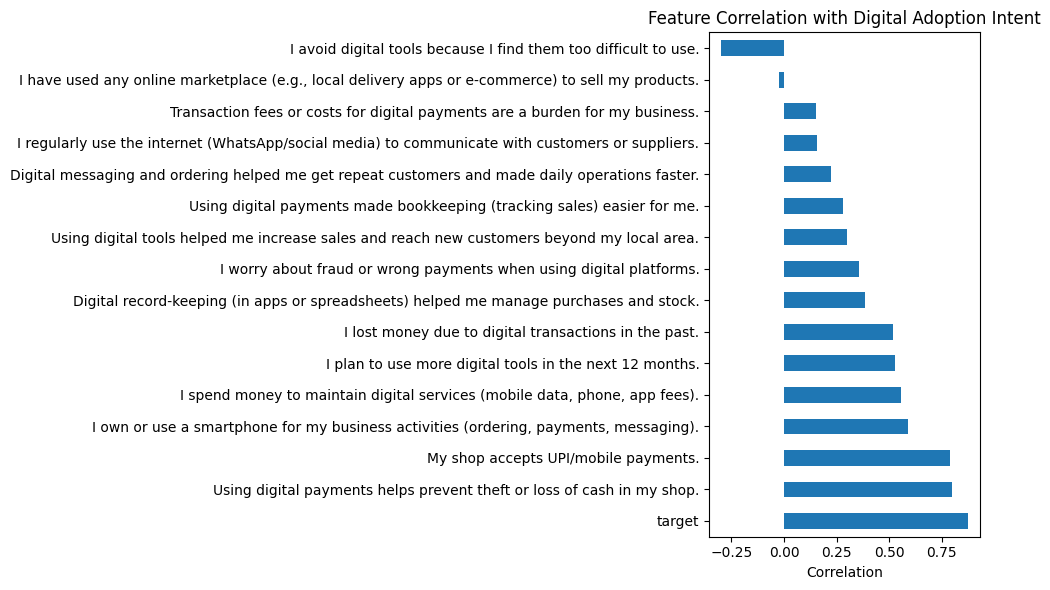

In [14]:
# Analyze correlation with target variable to identify influencing factors
correlation_with_target = df.corr()[target_col].sort_values(ascending=False)
print("Correlation with target variable:")
print(correlation_with_target)

# Visualize top influencing factors
plt.figure(figsize=(10, 6))
correlation_with_target.drop(target_col).plot(kind='barh')
plt.xlabel('Correlation')
plt.title('Feature Correlation with Digital Adoption Intent')
plt.tight_layout()
plt.show()

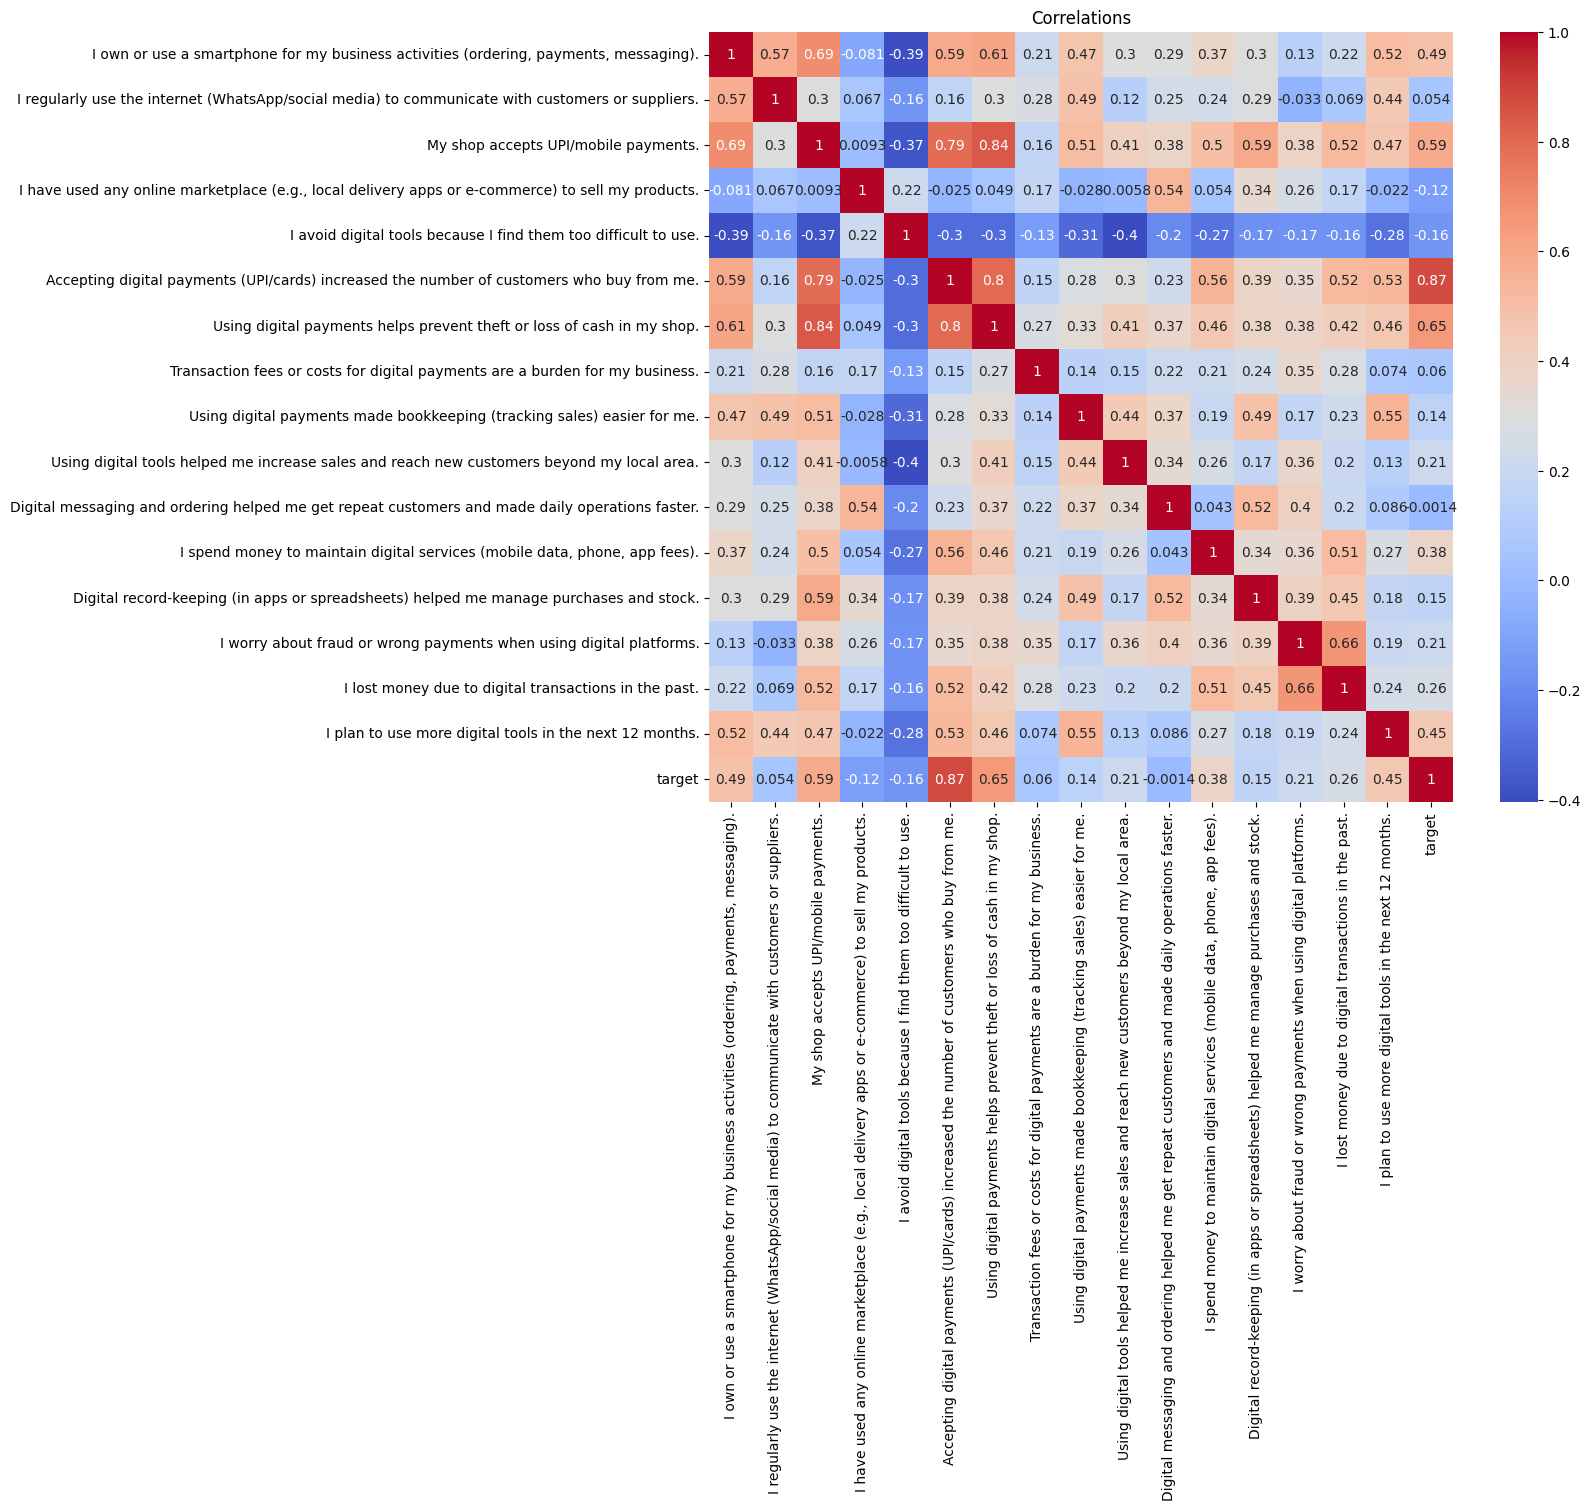

In [15]:
# Visualize correlation matrix between all features to identify relationships
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlations')
plt.show()

In [16]:
# Split data into training and testing sets, train Random Forest model, and evaluate accuracy
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f'Accuracy: {acc:.2f}')

Accuracy: 0.60


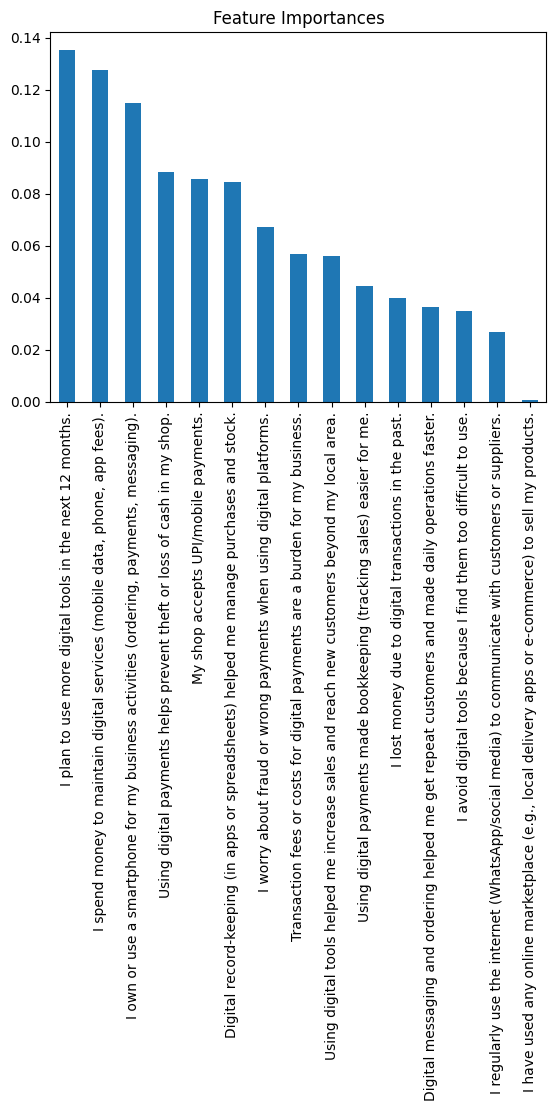

In [17]:
# Extract and visualize feature importances from the trained Random Forest model
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).plot.bar()
plt.title('Feature Importances')
plt.show()

In [18]:
# Train and compare multiple ML models (Logistic Regression, Random Forest, Gradient Boosting, SVM) with performance metrics
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42, n_estimators=100),
    'SVM': SVC(random_state=42, probability=True)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    }
    
    # print(f'\n{name}:')
    # print(f'  Accuracy: {accuracy:.4f}')
    # print(f'  Precision: {precision:.4f}')
    # print(f'  Recall: {recall:.4f}')
    # print(f'  F1-Score: {f1:.4f}')

# Create comparison dataframe
results_df = pd.DataFrame(results).T
print('\n\nModel Comparison:')
print(results_df)



Model Comparison:
                     Accuracy  Precision    Recall  F1-Score
Logistic Regression       0.7        0.5  0.333333       0.4
Random Forest             0.6        0.0  0.000000       0.0
Gradient Boosting         0.6        0.0  0.000000       0.0
SVM                       0.7        0.0  0.000000       0.0


The models are simply predicting the majority class (0) for all samples. This happens when:

Test set contains only negative samples (target = 0)
Models learn that predicting "0" always gives 100% accuracy
No actual learning or pattern recognition occurred
The Real Issue:
Your target variable is extremely imbalanced - likely 95%+ of businesses are NOT planning to use digital tools, so the test set has no positive examples. The models achieve 100% accuracy by doing nothing useful: always predicting "will not adopt."